In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
from io import BytesIO
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

In [ ]:
#define my path in hard drive
# data_dir = "/Volumes/S/Capston/data2"
data_dir = "S:/Capston/data2"
SAVE_FOLDER = "S:/_tmp/"

In [ ]:
# Read CSV and making dataframe
df = pd.read_csv(os.path.join(data_dir,'train.csv'))
# sanity check
df.shape

In [ ]:
df.head()

In [ ]:
Root = "S:/Capston/data4"
df['path'] = [os.path.join(Root, str(int(patient)) + '.pt') for patient in df['patient_id']]

In [ ]:
df.head()

In [ ]:
# sanity check
df.loc[df['extravasation_injury']==df['extravasation_healthy']]

In [ ]:

# Separate the data into two DataFrames based on the outcome
df2 = df[['extravasation_injury', 'path']]
df2_y0 = df2.loc[df2['extravasation_injury'] == 0]
df2_y1 = df2.loc[df2['extravasation_injury'] == 1]

# Get the minimum number of samples for balancing
min_samples = min(len(df2_y0), len(df2_y1))

# Sample an equal number of samples from both classes
df_balanced = pd.concat([df2_y0.sample(min_samples, random_state=42), df2_y1.sample(min_samples, random_state=42)])

# Define a function to get random (X, y) pair
# def get_random_X_y_balanced(df):
#     random_row = df.sample(1).iloc[0]
#     tensor = torch.load(random_row['path'])
#     outcome = random_row['extravasation_injury']
    
#     return tensor, outcome

# Generate random (X, y) pairs
X, y = np.array(df_balanced.iloc[:,1]), np.array(df_balanced.iloc[:,0])

# Split your data into remain and testing sets

X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def get_model(width=128, height=128, depth=128):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=128)
model.summary()

# Train model

In [ ]:

# Split data into training and validation sets
X_train_path, X_val_path, y_train, y_val = train_test_split(X_remain, y_remain, test_size=0.2, random_state=42)
X_train = np.array([torch.load(path).numpy() for path in X_train_path])
X_val = np.array([torch.load(path).numpy() for path in X_val_path])

In [ ]:

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
import matplotlib.pyplot as plt
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [23]:

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

128/128 - 1191s - loss: 0.5833 - acc: 0.6914 - val_loss: 0.8827 - val_acc: 0.4844 - 1191s/epoch - 9s/step
Epoch 9/100
128/128 - 933s - loss: 0.5859 - acc: 0.6719 - val_loss: 0.9111 - val_acc: 0.4531 - 933s/epoch - 7s/step
Epoch 10/100
128/128 - 923s - loss: 0.5702 - acc: 0.7070 - val_loss: 0.9128 - val_acc: 0.4219 - 923s/epoch - 7s/step
Epoch 11/100
128/128 - 911s - loss: 0.5553 - acc: 0.7188 - val_loss: 0.9737 - val_acc: 0.4062 - 911s/epoch - 7s/step
Epoch 12/100
128/128 - 964s - loss: 0.5324 - acc: 0.7227 - val_loss: 0.9893 - val_acc: 0.4688 - 964s/epoch - 8s/step
Epoch 13/100
128/128 - 902s - loss: 0.5621 - acc: 0.7188 - val_loss: 0.9571 - val_acc: 0.4531 - 902s/epoch - 7s/step
Epoch 14/100
128/128 - 967s - loss: 0.5374 - acc: 0.7266 - val_loss: 0.9767 - val_acc: 0.4531 - 967s/epoch - 8s/step
Epoch 15/100
128/128 - 1111s - loss: 0.5390 - acc: 0.7148 - val_loss: 0.9932 - val_acc: 0.4062 - 1111s/epoch - 9s/step
Epoch 16/100
128/128 - 984s - loss: 0.5537 - acc: 0.7031 - val_loss: 0.997

# Visualizing model performance

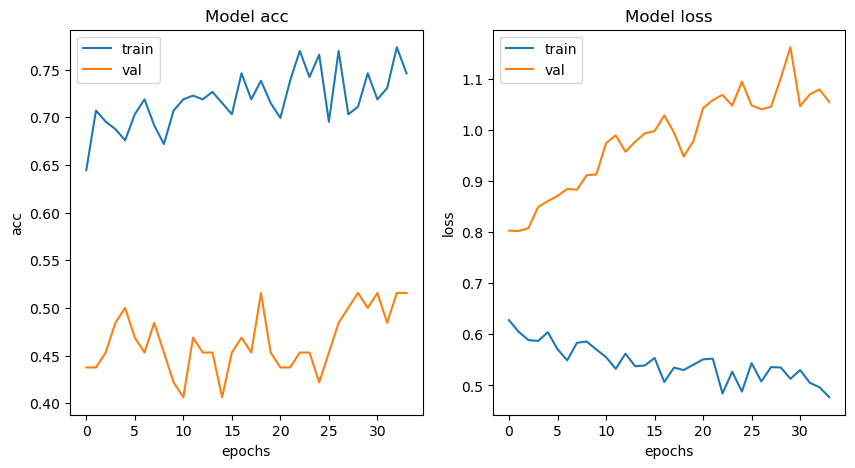

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])